In [1]:
import pandas as pd
import numpy as np
import math
import warnings

In [2]:
book = pd.read_parquet('../book.parquet')
trades = pd.read_parquet('../trades.parquet')
target = pd.read_parquet('../target.parquet')
ticker = pd.read_parquet('../ticker.parquet')

In [3]:
book['local_timestamp'] = pd.to_datetime(book['local_timestamp'])
trades['local_ts'] = pd.to_datetime(trades['local_ts'])
ticker['local_ts'] = pd.to_datetime(ticker['local_ts'])
target['local_ts'] = pd.to_datetime(target['local_ts'])

end_time = '2023-03-22 02:00:00'
book = book[book['local_timestamp']<end_time]
trades = trades[trades['local_ts']<end_time]
target = target[target['local_ts']<end_time]
ticker = ticker[ticker['local_ts']<end_time]

df = pd.merge_asof(left = target, right = ticker, on='local_ts', direction='backward')
df.dropna(axis=0, how='any', inplace=True)

In [4]:
ff = book['local_timestamp']
ffs = sorted(ff)
problem_indexes = ff[ffs != ff].index
book.drop(problem_indexes, inplace = True)

df = pd.merge_asof(left = df, right = book, left_on = 'local_ts', right_on = 'local_timestamp', direction='backward')
df = pd.merge_asof(left = df, right = trades, left_on = 'local_ts', right_on = 'local_ts', direction='backward')
baaad = ['seq_x', 'symbol', 'timestamp', 'exchange', 'seq_y', 'remote_ts_x', 'remote_ts2_x', 'remote_ts_y', 'remote_ts2_y']
df.drop(columns = baaad, inplace = True)
tgt = df['target']
df.drop(columns = 'target', inplace = True)
df['target'] = tgt
df.reset_index(drop = True, inplace = True)
df.dropna(axis=0, how='any', inplace=True)

In [5]:
df.head()

,local_ts,bid_price,bid_amount,ask_price,ask_amount,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,...,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount,price,amount,side,target
27,2023-03-22 00:00:02.034828800,28090.8,0.002,28090.9,6.995,2023-03-22 00:00:00.485131264,28091.2,16.183,28091.1,0.001,...,28087.7,0.036,28093.7,0.001,28087.6,0.002,28091.0,0.003,S,0
28,2023-03-22 00:00:02.659586048,28090.8,0.002,28090.9,7.005,2023-03-22 00:00:02.065465600,28090.9,6.995,28090.8,0.002,...,28087.5,0.099,28093.5,0.401,28087.4,0.001,28091.0,0.003,S,0
29,2023-03-22 00:00:02.780739702,28090.8,0.002,28090.9,6.885,2023-03-22 00:00:02.691394048,28090.9,7.005,28090.8,0.002,...,28087.5,0.099,28093.5,0.401,28087.4,0.001,28090.9,0.547,B,0
30,2023-03-22 00:00:05.344112384,28090.8,0.002,28090.9,6.895,2023-03-22 00:00:05.073113344,28090.9,6.885,28090.8,0.002,...,28087.5,0.099,28093.5,0.401,28087.4,0.001,28090.9,0.547,B,-1
31,2023-03-22 00:00:05.349040896,28090.8,0.002,28090.9,6.777,2023-03-22 00:00:05.073113344,28090.9,6.885,28090.8,0.002,...,28087.5,0.099,28093.5,0.401,28087.4,0.001,28090.9,0.118,B,-1


1. Accumulation Distribution Line

In [6]:
def Accumulation_Distribution_Line(md, window=10):
    warnings.filterwarnings('ignore')
    
    C = md['price']
    C[:window-1] = np.nan
    L = md['price'].rolling(window).min()
    H = md['price'].rolling(window).max()
    
    MoneyFlowMultiplier = (2*C-L-H)/(H-L)
    MoneyFlowMultiplier.fillna(0, inplace = True)
    BlockPeriodVolume = md['price']
    MoneyFlowVolumet = MoneyFlowMultiplier * md['amount'].rolling(window).sum()
    
    ADL = MoneyFlowVolumet.cumsum()
    
    return ADL

In [7]:
df['ADL_10'] = Accumulation_Distribution_Line(df, 10)
df['ADL_20'] = Accumulation_Distribution_Line(df, 20)

2. Average_Directional_Index

In [8]:
def AverageDirectionalIndex(md, window=14, fillnans = True):
    
    L = md['price'].rolling(window).min()
    H = md['price'].rolling(window).max()
    CL = md['price']
    

    plusM = H - H.shift(1)
    minusM = L.shift(1) - L

    plusMindicator = (plusM >= minusM) * (plusM >= 0) * 1
    minusMindicator = (plusM <= minusM) * (minusM >= 0) * 1
    
    plusDM = plusM * plusMindicator
    minusDM = minusM * minusMindicator
    
    TR = pd.concat([H, CL.shift(1)], axis = 1).max(axis = 1) - pd.concat([L, CL.shift(1)], axis = 1).min(axis = 1)
    
    
    plusDI = (plusDM/TR).rolling(window-1).mean().shift(1) * (window-1)/window + (plusDM/TR)/window
    minusDI = (minusDM/TR).rolling(window-1).mean().shift(1) * (window-1)/window + (minusDM/TR)/window
    
    ADX = 100 * (abs(plusDI - minusDI)/(plusDI + minusDI)).rolling(window-1).mean().shift(1)*(window-1)/window + 100*(abs(plusDI - minusDI)/(plusDI + minusDI))/window
    
    if fillnans:
        ADX.fillna(method = 'ffill', inplace = True) 
    
    
    return ADX

In [9]:
df['ADX_10'] = AverageDirectionalIndex(df, 10, True)
df['ADX_20'] = AverageDirectionalIndex(df, 20, True)

3. Chande Momentum Oscillator

In [10]:
def Chande_Momentum_Oscillator(md, window=10, fillnans = True):
    updays = (md['price']/ (md['price'].shift(1)) > 1) * 1
    downdays = (md['price']/ (md['price'].shift(1)) < 1) * 1
    zerodays = (md['price']/ (md['price'].shift(1)) == 1) * 1
    
    CL_up = (md['price'] - (md['price'].shift(1))) * updays
    CL_down = -(md['price'] - (md['price'].shift(1))) * downdays
    
    Su = CL_up.rolling(window).sum()
    Sd = CL_down.rolling(window).sum()
    
    CMO = 100 * (Su - Sd)/(Su + Sd)
    
    if fillnans:
        CMO.fillna(method = 'ffill', inplace = True)
    
    return CMO

In [11]:
df['CMO_10'] = Chande_Momentum_Oscillator(df, 10, True)
df['CMO_20'] = Chande_Momentum_Oscillator(df, 20, True)

4. Momentum

In [12]:
def Momentum(DF):
    MOM = DF['price'] - DF['price'].shift(1)
    return MOM

In [13]:
df['Momentum'] = Momentum(df)

5. Rate of Change

In [14]:
def Rate_Of_Change(DF, window=10):
    ROC = (DF['price'] - DF['price'].shift(window)) / DF['price'].shift(window) * 100
    return ROC

In [15]:
df['ROC_10'] = Rate_Of_Change(df, 10)
df['ROC_20'] = Rate_Of_Change(df, 20)

6. Relative Strength Index

In [16]:
def Relative_Strength_Index(md, window=10, fillnans = True):
    CL = md['price'] - md['price'].shift(1)
    
    updays = (CL > 0) * 1
    downdays = (CL < 0) * 1
    zerodays = (CL == 0) * 1
    
    CL_up = CL * updays
    CL_down = -CL * downdays
    
    AG = CL_up.rolling(window).sum()
    AL = CL_down.rolling(window).sum()
    
    Relative_strength = AG/AL
    
    RSI = 100 - 100/(1 + Relative_strength)
    
    if fillnans:
        RSI.fillna(method = 'ffill', inplace = True)
    
    return RSI

In [17]:
df['RSI_10'] = Relative_Strength_Index(df,10)
df['RSI_20'] = Relative_Strength_Index(df,20)

7. Linear Regression Line

In [18]:
def Linear_Regression_Line(md, window_learning=10, window_forecasting=1, fillnans = True):
    X_train = md['price'].copy()
    y_train = md['price'].shift(-window_forecasting)
    
    X_mean = X_train.rolling(window_learning).mean()
    y_mean = y_train.rolling(window_learning).mean()
    
    XminusX_mean = X_train - X_mean
    YminusY_mean = y_train - y_mean
    
    b1 = (XminusX_mean * YminusY_mean).rolling(window_learning).sum() / (XminusX_mean * XminusX_mean).rolling(window_learning).sum()#ddd
    b1[b1 == np.inf] = np.nan
    b1[b1 == -np.inf] = np.nan
    b0 = y_mean - b1 * X_mean
    
    if fillnans:
        b1.fillna(method = 'ffill', inplace = True)
        b0.fillna(method = 'ffill', inplace = True)
    
        
    return b0, b1

In [19]:
df['LRL_first'], df['LRL_second'] = Linear_Regression_Line(df)

8. OBI

In [20]:
def Order_Book_Imbalance(md, depth = 5):
    ask_volumes = md[[f'asks[{i}].amount' for i in range(depth)]]
    bid_volumes = md[[f'bids[{i}].amount' for i in range(depth)]]
    
    Va = ask_volumes.mean(axis = 1)
    Vb = bid_volumes.mean(axis = 1)    
        
    OBI = (Vb-Va)/(Va+Vb)
    return OBI

In [21]:
df['OBI_5'] = Order_Book_Imbalance(df, 5)
df['OBI_10'] = Order_Book_Imbalance(df, 10)
df['OBI_15'] = Order_Book_Imbalance(df, 15)

9. Autocorrelation

In [22]:
def Autocorrelation(md, window=10, lag=10, fillnans = True):
    shifted = md['price'].shift(lag)
    
    std1 = md['price'].rolling(window).std()
    std2 = shifted.rolling(window).std()
    
    cov = (shifted * md['price']).rolling(window).mean() - shifted.rolling(window).mean() * md['price'].rolling(window).mean()
    correlation = cov/(std1*std2)
    
    correlation[correlation == np.inf] = np.nan
    
    if fillnans:
        correlation.fillna(method = 'ffill', inplace = True)
    
    return correlation

In [23]:
df['Autocorrelation_10'] = Autocorrelation(df,10)
df['Autocorrelation_20'] = Autocorrelation(df,20)

10. Partial Correlation

In [24]:
def PartialCorrelation(md, window=1000, lag=10):
    
    Prices = md['price'].copy()
    answ = pd.DataFrame(index = md.index)
    
    for i in range(1, lag + 1):
        shifted = Prices.shift(i)
        correlation = Prices.rolling(window).corr(shifted)
        answ[f'{i} coeff'] = correlation
        Prices -= correlation * shifted
    
    return answ

In [26]:
df['Partial'] = PartialCorrelation(df)['1 coeff']

11. Cointegration

In [27]:
def Cointegration(md, window=10, fillnans=True, method = 'total volume', depth = 25):
    
    ASK = md[[f'asks[{i}].amount' for i in range(depth)]]
    BID = md[[f'bids[{i}].amount' for i in range(depth)]]
    
    
    if method == 'by level':
        b1 = pd.DataFrame(index = ASK.index)
        b0 = pd.DataFrame(index = ASK.index)
        
        for i in range(depth):
            y = ASK[f'asks[{i}].amount']
            X = BID[f'bids[{i}].amount']

            X_mean = X.rolling(window).mean()
            y_mean = y.rolling(window).mean()

            XminusX_mean = X - X_mean
            YminusY_mean = y - y_mean

            b_1 = (XminusX_mean * YminusY_mean).rolling(window).sum() / (XminusX_mean * XminusX_mean).rolling(window).sum()#ddd
            b_1[b_1 == np.inf] = np.nan
            b_1[b_1 == -np.inf] = np.nan
            b_0 = y_mean - b_1 * X_mean
            
            b1[f'LVL {i}'] = b_1
            b0[f'LVL {i}'] = b_0

        
        
        
    elif method == 'total volume':
        y = ASK.sum(axis = 1)
        X = BID.sum(axis = 1)
        
        X_mean = X.rolling(window).mean()
        y_mean = y.rolling(window).mean()

        XminusX_mean = X - X_mean
        YminusY_mean = y - y_mean
        
        b1 = (XminusX_mean * YminusY_mean).rolling(window).sum() / (XminusX_mean * XminusX_mean).rolling(window).sum()#ddd
        b1[b1 == np.inf] = np.nan
        b1[b1 == -np.inf] = np.nan
        b0 = y_mean - b1 * X_mean
        
    return b0, b1

In [28]:
df['Cointegration_first'], df['Cointegration_second'] = Cointegration(df)

12. Adaptive Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
def AdaptiveLogreg(md, window=10, lag=1, method='binary', side = None, depth = 6):
    
    def logregfunc(X, xtest, y, method='binary'):
        lr = LogisticRegression(solver = 'newton-cg')
        lr.fit(X,y)
        
        if method=='triple':
            if set(y.unique()) == set([-1, 1]):
                ret = np.array([lr.predict_proba(xtest)[0][0], 0, lr.predict_proba(xtest)[0][1]])
            elif set(y.unique()) == set([0, 1]):
                ret = np.array([0, lr.predict_proba(xtest)[0][0], lr.predict_proba(xtest)[0][1]])
            elif set(y.unique()) == set([-1, 0]):
                ret = np.array([lr.predict_proba(xtest)[0][0], lr.predict_proba(xtest)[0][1], 0])
            else:
                ret = np.array([lr.predict_proba(xtest)[0][0], lr.predict_proba(xtest)[0][1], lr.predict_proba(xtest)[0][2]])
                
        if method=='binary':
            ret = np.array([lr.predict_proba(xtest)[0][0], lr.predict_proba(xtest)[0][1]])
            
        return ret
    
    
    
    
    
    # Для аска
    if side == 'ask':
        ASK = md[[f'asks[{i}].amount' for i in range(depth)]]
        ASK.fillna(0, inplace=True)
        
        # Изменение/не изменение
        if method == 'binary':
            tgts = (md['asks[0].price'] != md['asks[0].price'].shift(lag)) * 1
            tgts.fillna(0, inplace=True)
            answers = []
            
            for i in range(window, ASK.shape[0]-1):
                X = ASK[i-window:i]
                y = tgts[i-window:i]
                xtest = ASK.iloc[i:i+1]
                
                if sum(abs(y)) == 0:
                    preds = np.array([1,0])
                elif sum(y) == window:
                    preds = np.array([0,1])
                else:
                    preds = logregfunc(X, xtest, y, method='binary')     
                answers.append(preds)
            answ = pd.DataFrame(answers, columns=['Ask price=','Ask price+='])
                
        # 0/рост/падние
        if method == 'triple':
            tgts = ((md['bids[0].price'] > md['bids[0].price'].shift(lag)) * 1) + ((md['bids[0].price'] < md['bids[0].price'].shift(lag)) * -1)
            tgts.fillna(0, inplace=True)
            answers = []
            
            for i in range(window, ASK.shape[0]-1):
                X = ASK[i-window:i]
                y = tgts[i-window:i]
                xtest = ASK.iloc[i:i+1]
                
                if sum(abs(y)) == 0:
                    preds = np.array([0,1,0])
                elif sum(y) == window:
                    preds = np.array([0,0,1])
                elif sum(y) == -window:
                    preds = np.array([1,0,0])
                else:
                    preds = logregfunc(X, xtest, y, method='triple')
                answers.append(preds)
            answ = pd.DataFrame(answers, columns=['Ask price+','Ask price=','Ask price-'])
        
    # Для бида    
    if side == 'bid':
        BIDS = md[[f'bids[{i}].amount' for i in range(depth)]]
        BIDS.fillna(0, inplace=True)
        
        #Изменение/не изменение
        if method == 'binary':
            tgts = (md['bids[0].price'] != md['bids[0].price'].shift(lag)) * 1
            tgts.fillna(0, inplace=True)
            answers = []

            for i in range(window, BIDS.shape[0]-1):
                X = BIDS[i-window:i]
                y = tgts[i-window:i]
                xtest = BIDS.iloc[i:i+1]

                if sum(abs(y)) == 0:
                    preds = np.array([1,0])
                elif sum(y) == window:
                    preds = np.array([0,1])
                else:
                    preds = logregfunc(X, xtest, y, method='binary')
                answers.append(preds)
            answ = pd.DataFrame(answers, columns=['Bid price=','Bid price+='])
                
        # 0/рост/падние        
        if method == 'triple':
            tgts = ((md['bids[0].price'] > md['bids[0].price'].shift(lag)) * 1) + ((md['bids[0].price'] < md['bids[0].price'].shift(lag)) * -1)
            tgts.fillna(0, inplace=True)
            answers = []

            for i in range(window, BIDS.shape[0]-1):
                X = BIDS[i-window:i]
                y = tgts[i-window:i]
                xtest = BIDS.iloc[i:i+1]

                if sum(abs(y)) == 0:
                    preds = np.array([0,1,0])
                elif sum(y) == window:
                    preds = np.array([0,0,1])
                elif sum(y) == -window:
                    preds = np.array([1,0,0])
                else:
                    preds = logregfunc(X, xtest, y, method='triple')
                answers.append(preds)
            answ = pd.DataFrame(answers, columns=['Bid price+','Bid price=','Bid price-'])
    return answ

In [31]:
asks = AdaptiveLogreg(df, window=10, lag=1, method='binary', side = 'ask', depth = 6)
bids = AdaptiveLogreg(df, window=10, lag=1, method='binary', side = 'bid', depth = 6)

In [32]:
df['ALR_ask_6_first'], df['ALR_ask_6_second'] = asks['Ask price='], asks['Ask price+=']
df['ALR_bid_6_first'], df['ALR_bid_6_second'] = bids['Bid price='], bids['Bid price+=']

13. Realized Volatility

In [33]:
def Realized_Volatility(md, depth):
    delta = pd.DataFrame({'delta' : md['mid_price']-md['mid_price'].shift(1)})
    delta.fillna(0, inplace=True)
    delta = delta*delta
    tmp = delta.rolling(depth).sum()
    tmp.fillna(0, inplace=True)
    
    return tmp

In [34]:
df['mid_price'] = (df['asks[0].price']+df['bids[0].price'])/2

In [35]:
df['Realized_Volatility_10'] = Realized_Volatility(df, 10)
df['Realized_Volatility_20'] = Realized_Volatility(df, 20)

14. Realized Kernel 

In [36]:
def RealizedKernel(md, horizon=7, window=1000, kernel = 'Bartlett'):
    
    def k(x, kernel):
        if kernel == 'Bartlett':
            return 1-x
        

    returns = md['price'] - md['price'].shift(1)
    
    
    shifts_covs = pd.DataFrame(index=md.index)
    for i in range(1,horizon+1):
        shifts_covs[f'h={i}'] = returns.rolling(window).cov(returns.shift(i)) * window * k(x=(i-1)/horizon, kernel=kernel)
    for i in range(-horizon,0):
        shifts_covs[f'h={i}'] = returns.rolling(window).cov(returns.shift(i)) * window * k(x=(-i+1)/horizon, kernel=kernel)
    
    
    variance = md['price'].rolling(window).var()
    
    K = variance + shifts_covs.sum(axis=1)
    
    return K

In [37]:
df['Realized_Kernel'] = RealizedKernel(df)

15. Realized Bipower Variation 

In [38]:
#for jump variation

In [39]:
def Realized_Bipower_Variation(md,depth):
    delta = pd.DataFrame({'delta' : md['mid_price']-md['mid_price'].shift(1)})
    delta.fillna(0, inplace=True)
    shifted = delta.shift(1)
    shifted.fillna(0, inplace=True)
    another_delta = delta*shifted
    tmp = another_delta.rolling(depth).sum()
    tmp.fillna(0, inplace=True)
    md['Realized_Bipower_Volatility'] = tmp
    md['Realized_Bipower_Volatility'] = md['Realized_Bipower_Volatility'].apply(lambda x: x*math.pi*0.5)

In [40]:
Realized_Bipower_Variation(df, 10)

16. Jump Variation

In [41]:
def Jump_Variation(md):
    md['Jump_Variation'] = md['Realized_Volatility_10']-md['Realized_Bipower_Volatility']
    md[md['Jump_Variation']<0]=0

In [42]:
Jump_Variation(df)

добавим фичи из прошлой статьи

In [ ]:
df['PRET'] = df['price'].pct_change(fill_method='ffill') * 10000

bids_amount_columns = ['bids['+str(i)+'].amount' for i in range(25)]
asks_amount_columns = ['asks['+str(i)+'].amount' for i in range(25)]
buy_volume = df[bids_amount_columns].apply(lambda row: row.sum(), axis=1)
sell_volume = df[asks_amount_columns].apply(lambda row: row.sum(), axis=1)
df['TFI'] = buy_volume - sell_volume

будем предсказывать отклонение цены от мидпрайса на .5-1.0 секунды вперед

In [ ]:
df.dropna(axis=0, how='any', inplace=True)

In [ ]:
df = df.reset_index()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_score,recall_score,confusion_matrix, f1_score
import catboost as cb
from catboost import CatBoostClassifier, CatBoostRegressor

In [ ]:
y = df['target']
df.drop(columns='target',inplace=True)

In [ ]:
df.drop(columns='mid_price', inplace=True)

In [ ]:
df_total = df.iloc[:,110:]

In [ ]:
df_total.shape #32 фичи

(792091, 32)

In [ ]:
train_dataset = cb.Pool(X_train, y_train)
params = {'depth' : [4,6,8]}
catboost_class = CatBoostClassifier(logging_level='Silent')
catboost_class.grid_search(params, train_dataset, cv=3)

0:	loss: 0.6911005	best: 0.6911005 (0)	total: 46.2s	remaining: 1m 32s
1:	loss: 0.5941592	best: 0.5941592 (1)	total: 1m 45s	remaining: 52.9s
2:	loss: 0.4898100	best: 0.4898100 (2)	total: 3m 54s	remaining: 0us
Estimating final quality...


{'params': {'depth': 8},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
       

In [ ]:
## metric
import numpy as np
from sklearn.metrics import confusion_matrix

def metric(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    weight_matrix = np.array([
        [1.9,     0,    -2],
        [-0.3,    0,    -0.3],
        [-2,      0,     1.9]
    ])
    
    hit_matrix = conf_matrix * weight_matrix
    hit_matrix_sum = np.sum(hit_matrix)
    action_count = np.sum(conf_matrix[:, 0]) + np.sum(conf_matrix[:, 2])
    if action_count == 0:
        return 0
    else:
        return hit_matrix_sum / np.sqrt(action_count)

In [ ]:
y_pred_test = catboost_class.predict(X_test)

In [ ]:
metric(y_pred_test, y_test)

513.8321994134436

In [86]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Feature Importance')

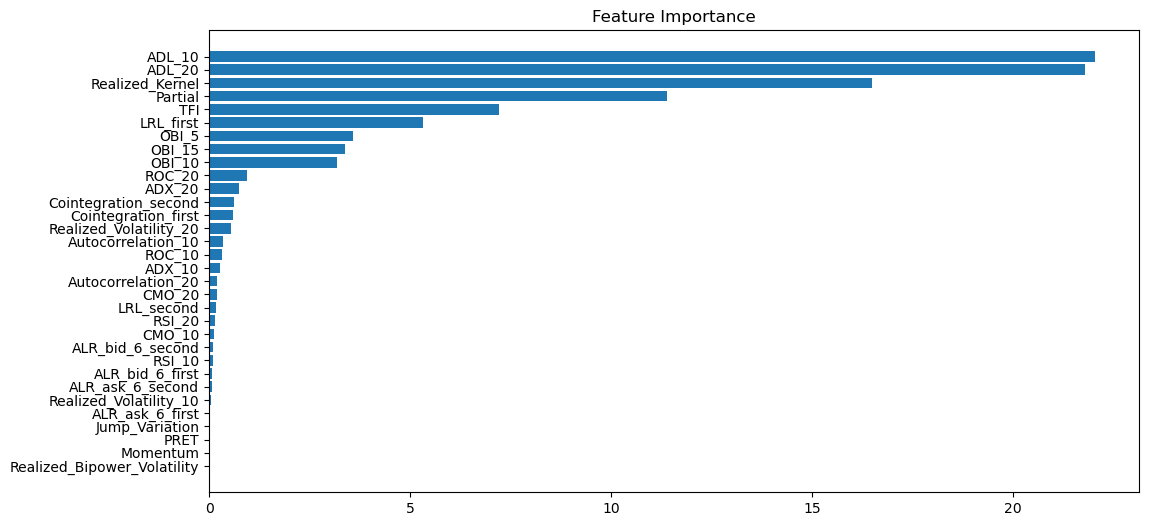

In [87]:
feature_importance = catboost_class.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


In [101]:
cols = np.array(X_test.columns)[sorted_idx][-7:]

In [102]:
ddf = pd.DataFrame()

In [103]:
for x in cols:
    ddf[f'{x}'] = df_total[x]

In [104]:
ddf.corr()

,OBI_5,LRL_first,TFI,Partial,Realized_Kernel,ADL_20,ADL_10
OBI_5,1.000000,-0.000180,0.747742,0.011055,0.002904,0.024535,0.028604
LRL_first,-0.000180,1.000000,-0.000694,-0.001488,-0.023936,-0.048516,-0.049909
TFI,0.747742,-0.000694,1.000000,0.013963,0.003242,0.027355,0.038772
Partial,0.011055,-0.001488,0.013963,1.000000,0.129508,0.107381,0.106657
Realized_Kernel,0.002904,-0.023936,0.003242,0.129508,1.000000,0.101408,0.102739
ADL_20,0.024535,-0.048516,0.027355,0.107381,0.101408,1.000000,0.990279
ADL_10,0.028604,-0.049909,0.038772,0.106657,0.102739,0.990279,1.000000


In [92]:
df_total.corr()

,ADL_10,ADL_20,ADX_10,ADX_20,CMO_10,CMO_20,Momentum,ROC_10,ROC_20,RSI_10,...,ALR_ask_6_second,ALR_bid_6_first,ALR_bid_6_second,Realized_Volatility_10,Realized_Volatility_20,Realized_Kernel,Realized_Bipower_Volatility,Jump_Variation,PRET,TFI
ADL_10,1.000000,0.990279,-0.014376,-0.022864,-0.016533,-0.009874,2.401062e-03,0.008428,0.012531,-0.016470,...,0.031290,-0.025734,0.026624,0.003394,0.004733,0.102739,0.005226,0.003334,0.010870,0.038772
ADL_20,0.990279,1.000000,-0.008353,-0.022254,-0.020459,-0.013582,2.438150e-03,0.008392,0.012602,-0.020391,...,0.030934,-0.024687,0.025655,0.003396,0.004700,0.101408,0.005274,0.003335,0.011937,0.027355
ADX_10,-0.014376,-0.008353,1.000000,0.239675,0.003229,0.002703,-2.631175e-03,-0.005358,-0.007432,0.005111,...,-0.010522,0.033116,-0.008347,-0.004709,-0.028033,-0.015580,-0.006398,-0.004635,0.329810,-0.000812
ADX_20,-0.022864,-0.022254,0.239675,1.000000,0.001214,0.002395,-6.220832e-03,-0.010829,-0.004246,0.004089,...,-0.010114,0.048784,-0.010935,-0.005516,-0.006781,0.012280,-0.001277,-0.005502,0.503904,0.006739
CMO_10,-0.016533,-0.020459,0.003229,0.001214,1.000000,0.943192,7.149622e-02,0.219153,0.245371,0.999984,...,-0.026798,-0.035378,0.035502,-0.007324,-0.005722,0.002124,-0.001599,-0.007307,0.000402,0.329781
CMO_20,-0.009874,-0.013582,0.002703,0.002395,0.943192,1.000000,6.949034e-02,0.208063,0.281355,0.943177,...,-0.027462,-0.037261,0.037387,-0.009843,-0.010986,0.003525,-0.001574,-0.009828,0.000356,0.353290
Momentum,0.002401,0.002438,-0.002631,-0.006221,0.071496,0.069490,1.000000e+00,0.317852,0.234595,0.071495,...,-0.003799,-0.009773,0.009800,-0.007331,-0.002938,0.002980,0.001546,-0.007351,0.000769,0.048566
ROC_10,0.008428,0.008392,-0.005358,-0.010829,0.219153,0.208063,3.178519e-01,1.000000,0.736928,0.219149,...,-0.015589,-0.024507,0.024574,-0.118863,-0.079119,0.019306,-0.008096,-0.118798,0.000232,0.193372
ROC_20,0.012531,0.012602,-0.007432,-0.004246,0.245371,0.281355,2.345948e-01,0.736928,1.000000,0.245367,...,-0.021087,-0.029348,0.029427,-0.207806,-0.201504,0.029553,-0.012232,-0.207715,0.000162,0.280446
RSI_10,-0.016470,-0.020391,0.005111,0.004089,0.999984,0.943177,7.149490e-02,0.219149,0.245367,1.000000,...,-0.026792,-0.034955,0.035507,-0.007322,-0.005719,0.002137,-0.001598,-0.007305,0.006108,0.329773
